# Lab 8


## Setup for SUSY Dataset

Use the SUSY dataset for the rest of this lab. Here is a basic setup.

In [1]:
# Our usual libraries...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
import tabulate

In [2]:
filename="../Lab.7/SUSY-small.csv"
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", 
          "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET",
          "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
df = pd.read_csv(filename, dtype='float64', names=VarNames)

In [3]:
print(df.shape)

(500000, 19)


## Scikit-Learn

[Scikit-learn](http://scikit-learn.org) is a rich python library for data science, including machine learning. For example, we can build a Fisher Discriminant (aka Linear Discriminant Analysis, or LDA). 

### Exercise 1: Install Scikit-Learn

Follow the [Installation Instructions](https://scikit-learn.org/stable/install.html) and install `scikit-learn` in your environment.

In [4]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


### Exercise 2: Read About Classifiers

#### Part a|
Scikit-learn offers an impressively comprehensive list of machine learning algorithms. Browse through [scikit-learn's documentation](https://scikit-learn.org/stable/index.html). You'll note the algorithms are organized into classification, regression, clustering, dimensionality reduction, model selection, and preprocessing. Browse through the list of [classification algorithms](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). 

#### Part b
Note scikit-learn's documentation is rather comprehensive. The documentation on [linear models](https://scikit-learn.org/stable/modules/linear_model.html) shows how classification problems are setup. Read about the first few methods and try to comprehend the example codes. Skim the rest of the document.

#### Part c
Read through the [LDA Documentation](https://scikit-learn.org/stable/modules/lda_qda.html).


### Exercise 3: Training a Classifier

Lets' repeat what we did manually in the previous lab using scikit-learn. We'll use a LDA classifier, which we can instanciate as follows:

In [4]:
import sklearn.discriminant_analysis as DA
Fisher=DA.LinearDiscriminantAnalysis()

As discussed in the lecture, to properly formulate our problem, we'll have to:

* Define the inputs (X) vs outputs (Y)
* Designate training vs testing samples (in order to get a unbias assessment of the performance of Machine Learning algorithms)

for example, here we'll take use 4M events for training and the remainder for testing.

In [5]:
#N_Train=4000000
N_Train = int((0.8) * len(df)) # use 80% for training
Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:]

X_Train=Train_Sample[VarNames[1:]]
y_Train=Train_Sample["signal"]

X_Test=Test_Sample[VarNames[1:]]
y_Test=Test_Sample["signal"]

Test_sig=Test_Sample[Test_Sample.signal==1]
Test_bkg=Test_Sample[Test_Sample.signal==0]


We can train the classifier as follow:

In [6]:
Fisher.fit(X_Train,y_Train)

LinearDiscriminantAnalysis()

We can plot the output, comparing signal and background:

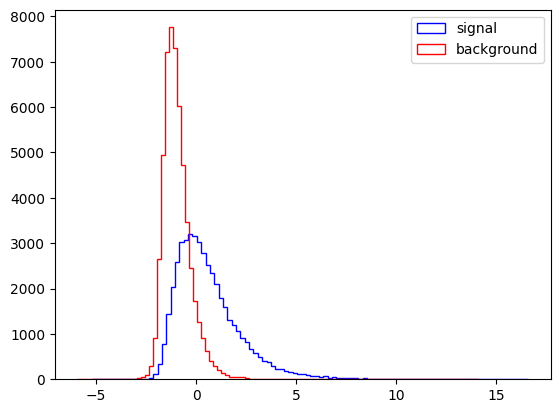

In [7]:
plt.figure()
plt.hist(Fisher.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="blue", label="signal",stacked=True)
plt.hist(Fisher.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="red", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

#### Part a

Compare ROC curves computed on the test versus training samples, in a single plot. Do you see a bias?

In [8]:
#PART a
from sklearn.metrics import roc_curve, auc

# Compute ROC curve - training sample
fpr_train, tpr_train, _ = roc_curve(y_Train, Fisher.decision_function(X_Train))
roc_auc_train = auc(fpr_train, tpr_train)

In [9]:
# Compute ROC curve - TEST sample
fpr_test, tpr_test, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))
roc_auc_test = auc(fpr_test, tpr_test)

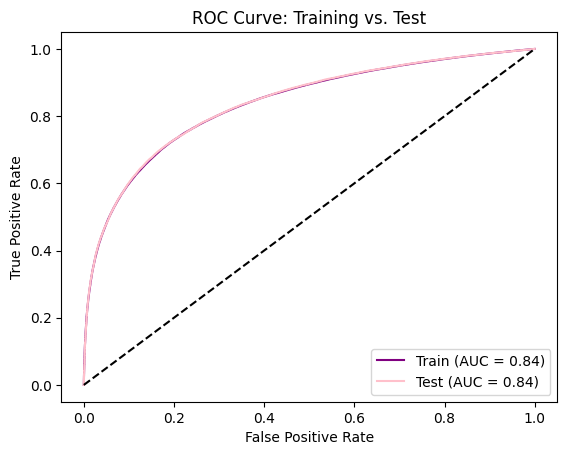

In [49]:
# Plotting both curves
plt.figure()
plt.plot(fpr_train, tpr_train, color='purple', label=f'Train (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='pink', label=f'Test (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Training vs. Test')
plt.legend(loc='lower right')
plt.show()

#### Part b

Train the Fisher performance of using the raw, features, and raw+features as input. Compare the performance one a single plot. 

In [11]:
# define input sets
RawNames = ["l_1_pT", "l_1_eta", "l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", "MET", "MET_phi"]
FeatureNames = list(set(VarNames[1:]) - set(RawNames))  # Derived features

In [12]:
# input combinations
X_Train_raw = Train_Sample[RawNames]
X_Train_features = Train_Sample[FeatureNames]
X_Train_both = Train_Sample[VarNames[1:]]  # Raw + Features

In [13]:
# train 3 LDAs
Fisher_raw = DA.LinearDiscriminantAnalysis().fit(X_Train_raw, y_Train)
Fisher_features = DA.LinearDiscriminantAnalysis().fit(X_Train_features, y_Train)
Fisher_both = DA.LinearDiscriminantAnalysis().fit(X_Train_both, y_Train)


In [14]:
# compute ROC curves - test sample
fpr_raw, tpr_raw, _ = roc_curve(y_Test, Fisher_raw.decision_function(X_Test[RawNames]))
fpr_features, tpr_features, _ = roc_curve(y_Test, Fisher_features.decision_function(X_Test[FeatureNames]))
fpr_both, tpr_both, _ = roc_curve(y_Test, Fisher_both.decision_function(X_Test[VarNames[1:]]))

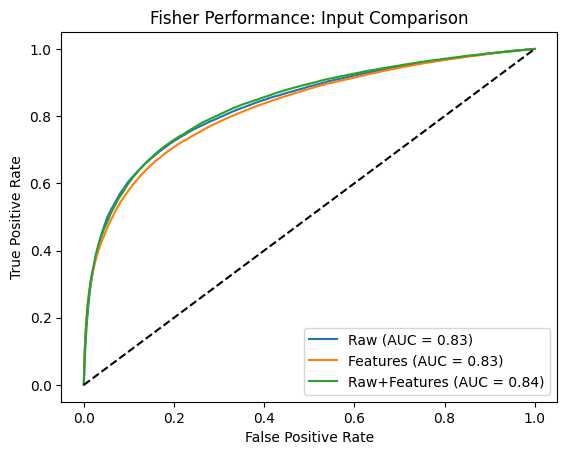

In [15]:
# Plot all curves
plt.figure()
plt.plot(fpr_raw, tpr_raw, label=f'Raw (AUC = {auc(fpr_raw, tpr_raw):.2f})')
plt.plot(fpr_features, tpr_features, label=f'Features (AUC = {auc(fpr_features, tpr_features):.2f})')
plt.plot(fpr_both, tpr_both, label=f'Raw+Features (AUC = {auc(fpr_both, tpr_both):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Fisher Performance: Input Comparison')
plt.legend(loc='lower right')
plt.show()

- The LDA model performs well in distinguishing between signal and background events (AUC around 0.83-0.84).

- It generalizes well to unseen data (similar AUC on training and test sets).

- Combining both sets of features leads to a small increase in performance, suggesting that the features offer some additional, but not drastically significant, information for this linear model.

### Exercise 4: Comparing Techniques

#### Part a
Select 3 different classifiers from the techniques listed [here](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) to compare. Note that you can use the multi-layer perceptron to build a deep network, though training may be prohibitively slow. So avoid this technique.


- Logistic Regression (Linear)

- Random Forest (Ensemble)

- GradientBoosting


#### Part b

Write a function that takes an instantiated classifier and performs the comparison from part 3b. Use the function on your choice of functions in part a.

In [18]:
# load and prepare data
import pandas as pd
from sklearn.model_selection import train_test_split

filename = "../Lab.7/SUSY-small.csv"
VarNames = ["signal", "l_1_pT", "l_1_eta", "l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", 
            "MET", "MET_phi", "MET_rel", "axial_MET", "M_R", "M_TR_2", "R", "MT2", 
            "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]

df = pd.read_csv(filename, names=VarNames)
X = df[VarNames[1:]]  # Features
y = df["signal"]      # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# comparison function
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def compare_classifier(clf, X_train, y_train, X_test, y_test):
    """Train classifier and plot ROC curve"""
    clf.fit(X_train, y_train)
    
    # get scores
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test)[:,1]
    else:
        y_score = clf.decision_function(X_test)
    
    # Compute ROC
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_score = auc(fpr, tpr)
    
    # Plot
    plt.plot(fpr, tpr, label=f'{clf.__class__.__name__} (AUC={auc_score:.3f})')
    return auc_score

In [22]:
# Initialize classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

classifiers = [
    LogisticRegression(max_iter=1000),
    RandomForestClassifier(n_estimators=50),
    GradientBoostingClassifier(n_estimators=50)
]

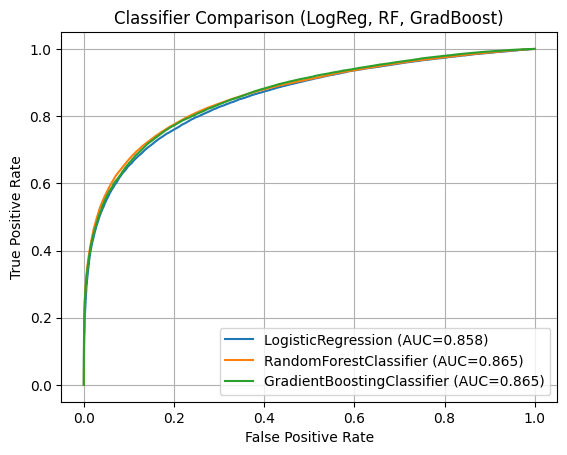

In [23]:
# Compare each
for clf in classifiers:
    compare_classifier(clf, X_train, y_train, X_test, y_test)

# Finalize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifier Comparison (LogReg, RF, GradBoost)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


#### Part c

Use the best method from part c to compute the maximal significance $\sigma_S= \frac{N_S}{\sqrt{N_S+N_B}}$ for the scenarios in lab 7.

In [25]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier

def compute_max_significance(clf, X_train, y_train, X_test, y_test, scenarios):
    """
    Compute maximal significance for given signal/background scenarios.
    
    Args:
        clf: Trained classifier
        scenarios: List of (N_S, N_B) tuples
    Returns:
        Dictionary of {(N_S, N_B): (max_σS, optimal_threshold)}
    """
    # get predicted probabilities - test set
    y_score = clf.predict_proba(X_test)[:, 1]
    
    # Sort scores descendingly
    sorted_idx = np.argsort(y_score)[::-1]
    y_score_sorted = y_score[sorted_idx]
    y_true_sorted = y_test.values[sorted_idx]
    
    # cumulative sums of signal/background
    tp = np.cumsum(y_true_sorted)  # True positives (signal)
    fp = np.cumsum(1 - y_true_sorted)  # False positives (background)
    
    results = {}
    for N_S, N_B in scenarios:
        # compute significance for all possible thresholds
        S_prime = (tp / len(y_test)) * N_S
        B_prime = (fp / len(y_test)) * N_B
        sigma_S = S_prime / np.sqrt(S_prime + B_prime + 1e-10) 
        
        # find maximum
        max_idx = np.argmax(sigma_S)
        results[(N_S, N_B)] = {
            'max_sigma': sigma_S[max_idx],
            'threshold': y_score_sorted[max_idx],
            'efficiency_S': tp[max_idx] / sum(y_test == 1),
            'efficiency_B': fp[max_idx] / sum(y_test == 0)
        }
    return results

In [26]:
# using GradientBoosting (from Part b)
gb = GradientBoostingClassifier(n_estimators=50, random_state=42)
gb.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=50, random_state=42)

In [27]:
# Lab 7 scenarios (N_Signal, N_Background)
scenarios = [
    (10, 100),
    (100, 1000),
    (1000, 10000),
    (10000, 100000)
]

# Compute results
results = compute_max_significance(gb, X_train, y_train, X_test, y_test, scenarios)

In [28]:
print("Maximal Significance for Lab 7 Scenarios:")
print("{:<15} {:<10} {:<15} {:<15} {:<15}".format(
    "Scenario (S,B)", "σS_max", "Threshold", "ϵ_Signal", "ϵ_Background"))
for (N_S, N_B), res in results.items():
    print(f"({N_S:5},{N_B:6})  {res['max_sigma']:10.3f}  {res['threshold']:15.3f}  "
          f"{res['efficiency_S']:15.3f}  {res['efficiency_B']:15.3f}")

Maximal Significance for Lab 7 Scenarios:
Scenario (S,B)  σS_max     Threshold       ϵ_Signal        ϵ_Background   
(   10,   100)       1.148            0.805            0.432            0.018
(  100,  1000)       3.631            0.805            0.432            0.018
( 1000, 10000)      11.483            0.805            0.432            0.018
(10000,100000)      36.311            0.805            0.432            0.018


### Exercise 5: Metrics

Scikit-learn provides methods for computing the FPR, TPR, ROC, AUC metrics. For example:

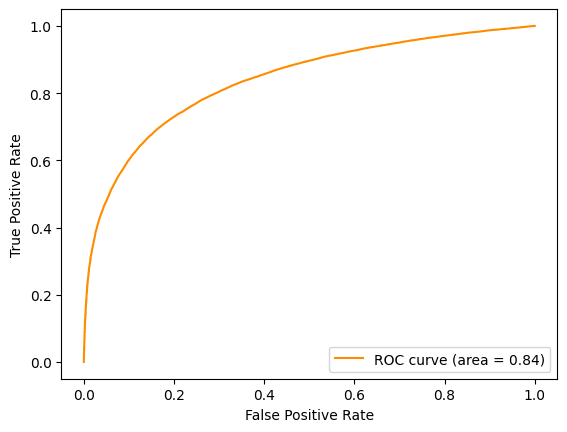

In [40]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()


#### Part a
TPR/FPR/ROC/AUC are one way of assessing the quality of a classifier. Read about [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall), [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision), and [F-score](https://en.wikipedia.org/wiki/F-score).

#### Part b
Look through [model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html#) documentation. Using scikit-learns tools, compute TPR, FPR, ROC, AUC, Precision, Recall, F1 score, and accuracy for the method you selected in 4c above and each scenario. Make a nice table, which also includes the maximal significance. 


In [41]:
import pandas as pd
from sklearn.metrics import (roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score)
from IPython.display import HTML

In [45]:
def evaluate_classifier(clf, X_test, y_test, scenarios, optimal_thresholds):
    """Compute all metrics for each scenario"""
    results = []
    
    # get predicted probabilities
    y_score = clf.predict_proba(X_test)[:, 1]
    
    # compute threshold-independent metrics
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    for scenario in scenarios:
        N_S, N_B = scenario
        threshold = optimal_thresholds[scenario]
        
        # applying threshold to get binary predictions
        y_pred = (y_score > threshold).astype(int)
        
        # Compute metrics
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        fpr_value = sum((y_pred == 1) & (y_test == 0)) / sum(y_test == 0)
        
        # Calculate significance
        sig = (recall * N_S) / np.sqrt(recall * N_S + fpr_value * N_B)
        
        results.append({
            'Scenario': f"{N_S}/{N_B}",
            'Threshold': f"{threshold:.3f}",
            'TPR (Recall)': f"{recall:.3f}",
            'FPR': f"{fpr_value:.3f}",
            'Precision': f"{precision:.3f}",
            'F1': f"{f1:.3f}",
            'Accuracy': f"{accuracy:.3f}",
            'AUC': f"{roc_auc:.3f}",
            'Max σS': f"{sig:.1f}"
        })
    
    return pd.DataFrame(results)

In [46]:
# Using results (from 4c)
scenarios = [
    (10, 100),
    (100, 1000),
    (1000, 10000),
    (10000, 100000)
]

optimal_thresholds = {
    (10, 100): 0.805,
    (100, 1000): 0.805,
    (1000, 10000): 0.805,
    (10000, 100000): 0.805
}

In [47]:
# Creating table
metrics_df = evaluate_classifier(gb, X_test, y_test, scenarios, optimal_thresholds)
display(HTML(metrics_df.to_html(index=False)))

Scenario,Threshold,TPR (Recall),FPR,Precision,F1,Accuracy,AUC,Max σS
10/100,0.805,0.432,0.018,0.953,0.594,0.730,0.865,1.7
100/1000,0.805,0.432,0.018,0.953,0.594,0.730,0.865,5.5
1000/10000,0.805,0.432,0.018,0.953,0.594,0.730,0.865,17.4
10000/100000,0.805,0.432,0.018,0.953,0.594,0.730,0.865,55.1
